In [16]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets, sklearn.preprocessing, sklearn.model_selection

# Define the sign function
def sign(x):
    return 0 if x < 0 else 1

## Normalization

Before we look to nonlinearly separable data, let's look at the normalization. During normalization, we standardize each datapoint, si it's vector have length 1. We can do that simply by deviding it by the length of the vector itself.

$$
\pmb{w_{norm}} = \frac{\pmb{w}}{|\pmb{w}|}=\frac{\pmb{w}}{\sqrt{\sum_i^D w_i^2}}
$$ 

Note, that this modification doesn't change the solution, as the hyperplane separating the original data separates the normalized data as well. For example let's look at the example from the previous notebook.

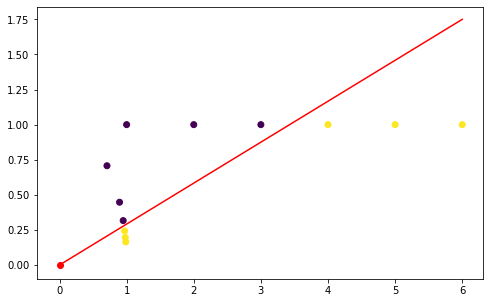

In [2]:
data = np.array([[1,1],[2,1],[3,1],[4,1],[5,1],[6,1]])
classes = np.array([0,0,0,1,1,1])
lengths = np.sqrt((data * data).sum(axis=1))
data_normalized = data / lengths[:,None]
plt.figure(figsize=(8,5))
plt.scatter(data[:,0],data[:,1], c = classes)
plt.scatter(data_normalized[:,0], data_normalized[:,1], c=classes)
plt.scatter(0,0,c='r')
plt.plot([0,6],[0,1.75], c='r')
plt.show()

By using normalization, all the data points' vectors will have length equal to one, so all the data points will influence the norm of the separating hyperplane only by it's angle, not based on it's length. In the result, each of the datapoint will influence the norm by the same "strength". 

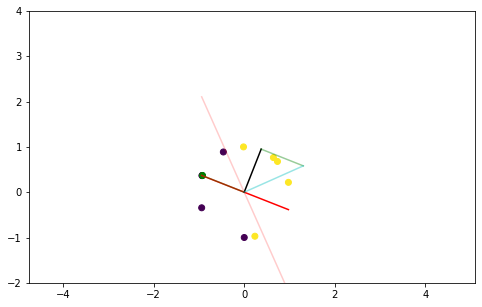

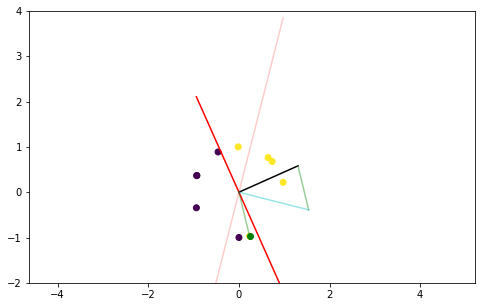

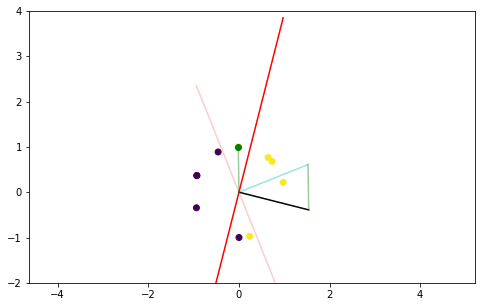

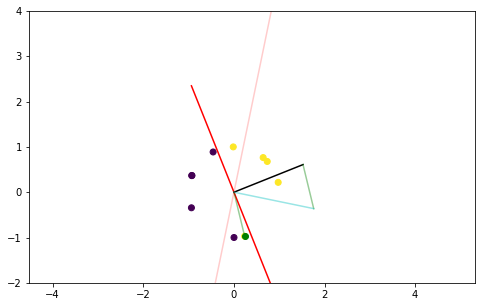

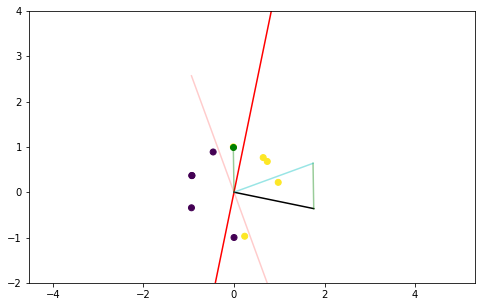

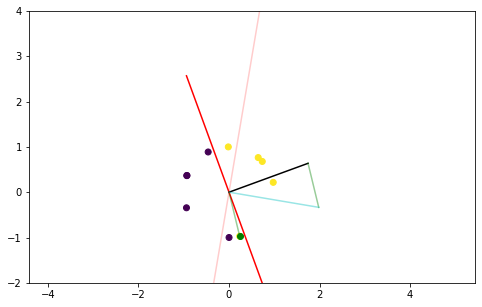

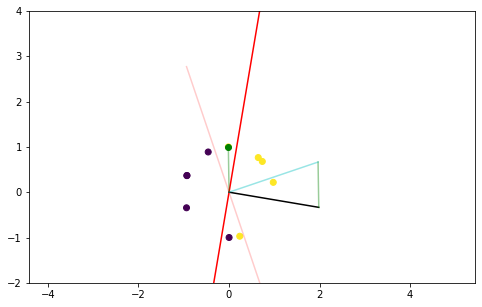

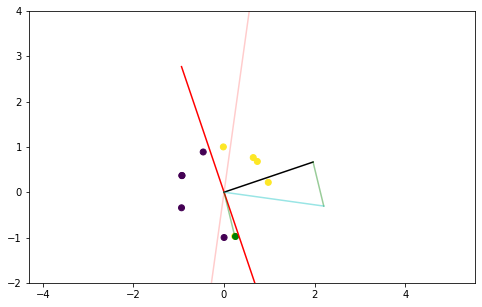

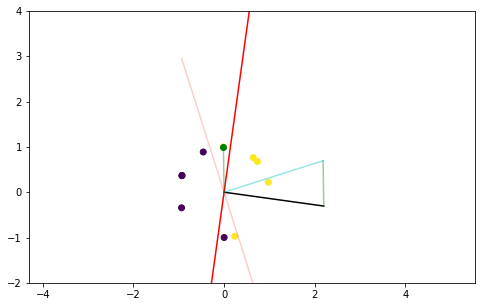

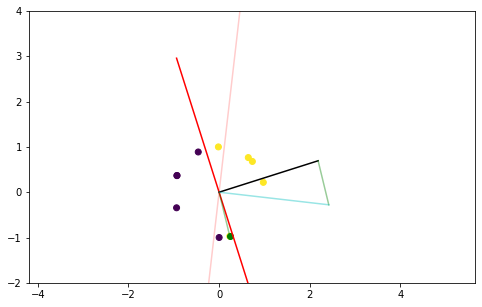

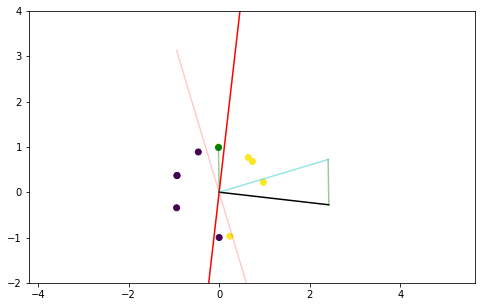

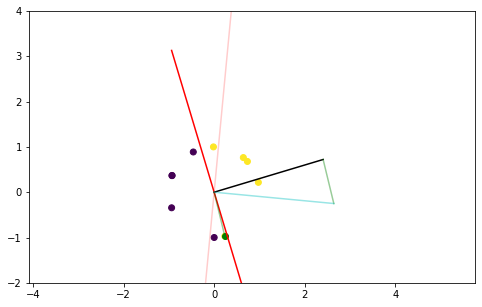

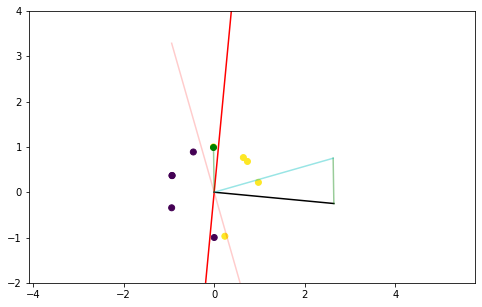

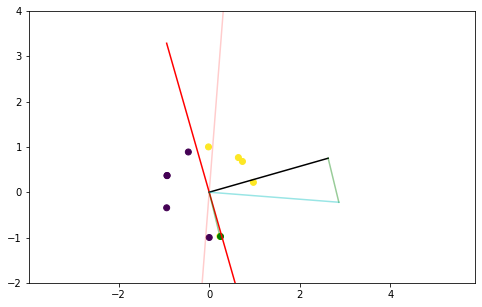

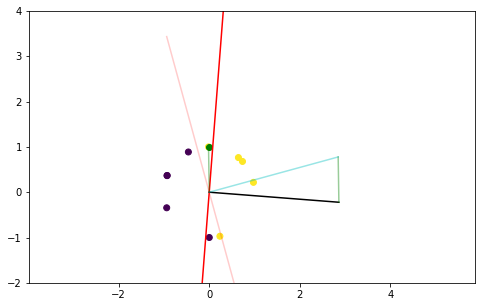

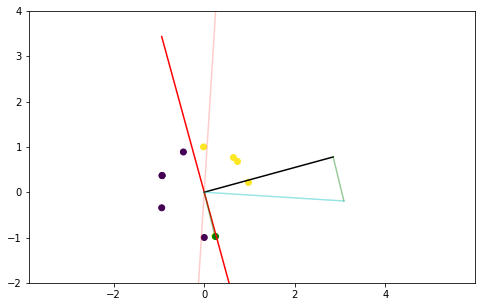

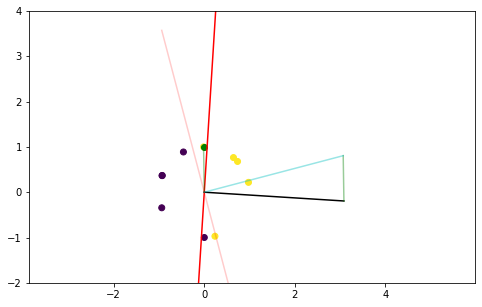

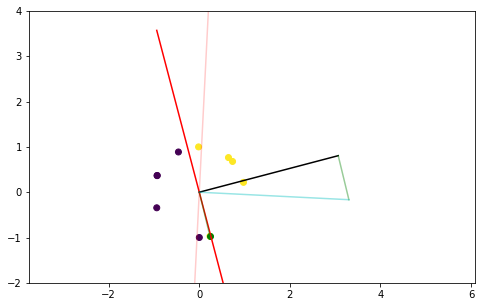

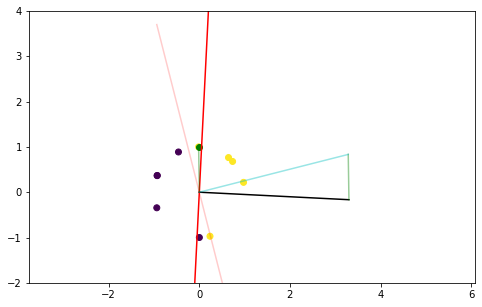

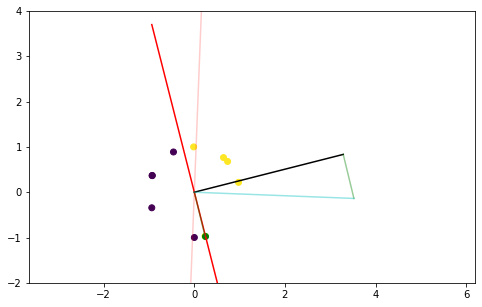

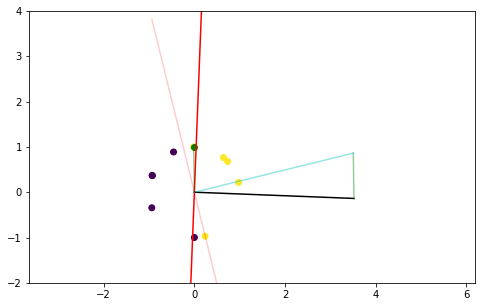

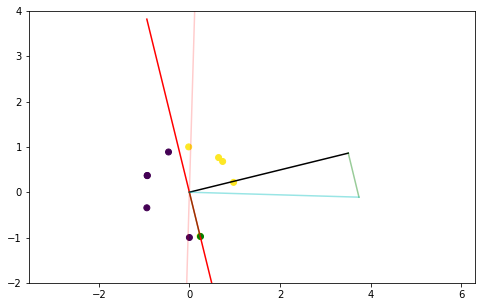

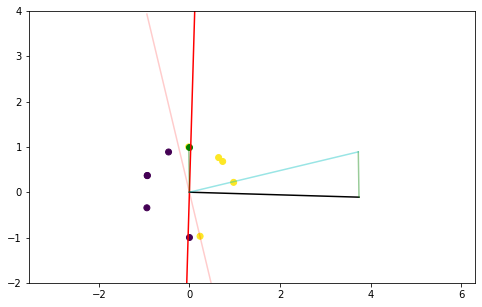

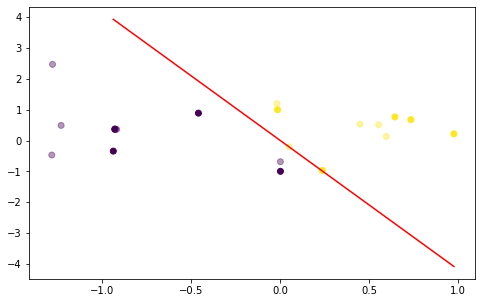

In [3]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=10, 
    n_features=2, 
    centers=[[-1,0.4],[1,0.6]], 
    cluster_std=0.8, 
    random_state=51
)
data_norm = sklearn.preprocessing.normalize(data)

# PERCEPTRON TRAINING
# Initialize the weights
weights = np.random.RandomState(42).uniform(size=2)

# Iterate until convergence
weights_changed = True
while weights_changed:
    weights_changed = False
    # for every instance in the data
    for instance, target in zip(data_norm, classes):
        # predict the output of the perceptron
        prediction = sign(instance @ weights)
        # update the weights
        weights_new = weights + (target - prediction) * instance
        
        # plot the change
        if (weights != weights_new).any():
            slope = - weights[0] / weights[1]  # calculate the slope
            plt.figure(figsize=(8, 5))
            plt.plot(
                [data_norm.min(axis=0)[0], data_norm.max(0)[0]], 
                [slope * data_norm.min(axis=0)[0], slope * data_norm.max(axis=0)[0]], 
                c='r')  # plot the separating line
            plt.plot([0, weights[0]],[0, weights[1]], c='black')  # plot the norm
            plt.scatter(data_norm[:,0], data_norm[:,1], c=classes)  # plot the data
            plt.scatter(instance[0], instance[1], c='g')  # plot the missclassified instance
            plt.plot([0, instance[0]], [0, instance[1]], c='g', alpha=0.4)  # plot the instance vector
            plt.plot(
                [weights[0], weights[0] + (target - prediction) * instance[0]], 
                [weights[1], weights[1] + (target - prediction) * instance[1]],
                c='g', alpha=0.4)  # plot the instance vector from the normal
            plt.plot(
                [0, weights[0] + (target - prediction) * instance[0]], 
                [0, weights[1] + (target - prediction) * instance[1]], 
                c='c', alpha=0.4)  # plot new normal
            slope_new = - weights_new[0] / weights_new[1]  # calculate the slope of new line
            plt.plot(
                [data_norm.min(axis=0)[0], data_norm.max(0)[0]], 
                [slope_new * data_norm.min(axis=0)[0], slope_new * data_norm.max(axis=0)[0]], 
                c='r', alpha=0.2)  # plot the separating line
            plt.axis('equal')
            plt.ylim(-2,4)
            plt.show()
        
        weights_changed = weights_changed or (weights != weights_new).any()
        weights = weights_new
        
# PLOTTING THE FINAL WEIGHTS
slope = - weights[0] / weights[1]
plt.figure(figsize=(8, 5))
plt.scatter(data_norm[:,0], data_norm[:,1], c=classes)
plt.scatter(data[:,0], data[:,1], c=classes, alpha=0.4)
plt.plot(
    [data_norm.min(axis=0)[0], data_norm.max(0)[0]], 
    [slope * data_norm.min(axis=0)[0], slope * data_norm.max(axis=0)[0]], 
    c='r')
plt.show()

This example is extraordinary interesting. The line gets to state, where only the two points (the purple one on top and the yellow one on bottom) are sequentially missclassified. The algorithm always try to correct the error and move the hyperplane to correct way. As the norm size increase, the steps are getting smaller and smaller, until both data points are finally classified correctly.

# Nonlinearly separable data

What if we have nonlinearly separable data? As there will be always some datapoint, that would change the hyperplane, the perceptron algorithm never stops. We can limit the number of iterations, that the perceptron algorithm can perform. At the same time, I will remember how many consequencive datapoints were correctly classified. In the end, I will pick up the hyperplane, that best classified most of the datapoints.

Firstly, let's generate the data.

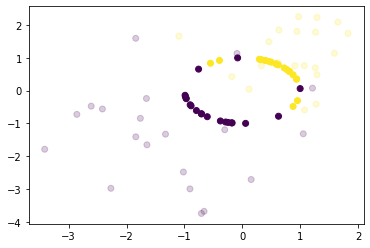

In [4]:
data_orig, classes = sklearn.datasets.make_blobs(
    n_samples=40,
    n_features=2,
    centers=([-1, -1], [1, 1]),
    cluster_std=(1.4, 0.8),
    random_state=42,
)
data = sklearn.preprocessing.normalize(data_orig)
plt.scatter(data_orig[:,0], data_orig[:,1], c=classes, alpha=0.2)
plt.scatter(data[:,0], data[:,1], c=classes)
plt.show()

The points are nearly linearly separable, except some of the purple dots. Note that data are already normalized - normalization always create hypersphere (that is circle in 2D) around the zero coordinate.

Now, I will implement the pocket algorithm [[1]](#Bibliography). I will allow maximum of 1000 iterations of the perceptron training. For the current weights, I will remember number of consequentive correctly classified data points. Moreover, I will remember weights of the hyperplane with the most correctly classified data points over the whole algorithm (remember it in the pocket). There is no suprise, that this hyperplane will be the result of the algorithm.

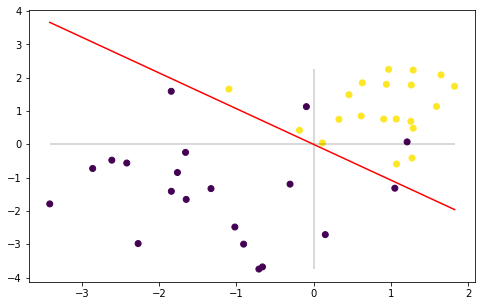

Consequentive correctly classified: 69


In [5]:
# Initialize the weights
rand = np.random.RandomState(44)
weights = rand.uniform(-2, 2, 2)

best_correctly_classified = -1
current_correctly_classified = -1
best_weights = None

# Iterate until max iteration reaches
for iteration in range(1000):
    permutation = rand.permutation(len(classes))
    for instance, target in zip(data[permutation], classes[permutation]):
        # predict the output of the perceptron
        prediction = sign(instance @ weights)
        # update the weights
        weights = weights + (target - prediction) * instance
        # pocket algorithm
        current_correctly_classified = current_correctly_classified + 1 if target == prediction else 0
        if current_correctly_classified > best_correctly_classified:
            best_correctly_classified = current_correctly_classified
            best_weights = weights.copy()

# Plot the hyperplane
slope = - best_weights[0] / best_weights[1]
plt.figure(figsize=(8, 5))
plt.scatter(data_orig[:,0], data_orig[:,1], c=classes)
plt.plot(
    [data_orig.min(axis=0)[0], data_orig.max(0)[0]], 
    [slope * data_orig.min(axis=0)[0], slope * data_orig.max(axis=0)[0]], 
    c='r')
plt.hlines(0, data_orig[:,0].min(), data_orig[:,0].max(), alpha=0.2)
plt.vlines(0, data_orig[:,1].min(), data_orig[:,1].max(), alpha=0.2)
plt.show()
print(f"Consequentive correctly classified: {best_correctly_classified}")

I will now show the missclassified examples green.

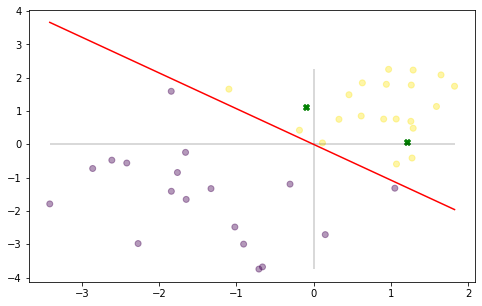

Accuracy 95.0% - 38 correct and 2 wrong


In [6]:
slope = - best_weights[0] / best_weights[1]
plt.figure(figsize=(8, 5))
wrong_data = classes != [sign(instance @ best_weights) for instance in data] # get missclassified data
correct_data = np.logical_not(wrong_data)
plt.scatter(data_orig[correct_data,0], data_orig[correct_data,1], c=classes[correct_data], alpha=0.4)
plt.scatter(data_orig[wrong_data,0], data_orig[wrong_data,1], marker='X', c='g') # plot missclassified data
plt.plot(
    [data_orig.min(axis=0)[0], data_orig.max(0)[0]], 
    [slope * data_orig.min(axis=0)[0], slope * data_orig.max(axis=0)[0]], 
    c='r')
plt.hlines(0, data_orig[:,0].min(), data_orig[:,0].max(), alpha=0.2)
plt.vlines(0, data_orig[:,1].min(), data_orig[:,1].max(), alpha=0.2)
plt.show()
print(f"Accuracy {correct_data.sum() / data.shape[0] * 100}% - {correct_data.sum()} correct and {wrong_data.sum()} wrong")

The result actually seems to be good enough. If I should draw a line, that separates the data the best, I would draw the simmilar line as well. It can be be shown, that the probability of finding the best separating hyperplane converge to 1 for number of iterations going to infinity [[1]](#Bibliography).

Now, we may finally wrap our Perceptron algorithm into the class. I will use the same interface as `sklearn` estimators use - `fit` method to train the estimator and `predict` method to predict results. Moreover, I will overload to call operator to have same meaning as `predict` method.

In [7]:
class Perceptron:
    def __init__(self, max_iters=100, random_state=None):
        self.max_iters = max_iters
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        pass
    
    def _sign(self, vals):
        if np.isscalar(vals):
            return np.array([1 if vals >= 0 else 0])
        vals[vals >= 0] = 1
        vals[vals < 0] = 0
        return vals
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        weights = rand.uniform(-2, 2, X.shape[1])
        
        best_correctly_classified = -1
        current_correctly_classified = -1
        best_weights = None

        old_weights = None
        for iteration in range(self.max_iters):
            # convergence check
            if (weights == old_weights).all():
                self.converged = True
                break
            old_weights = weights.copy()
            # data shuffle
            permutation = rand.permutation(len(y))
            # iterate over data
            for instance, target in zip(X[permutation], y[permutation]):
                # predict the output of the perceptron
                prediction = self._sign(instance @ weights)
                # update the weights
                weights = weights + (target - prediction) * instance
                # pocket algorithm
                current_correctly_classified = current_correctly_classified + 1 if target == prediction else 0
                if current_correctly_classified > best_correctly_classified:
                    best_correctly_classified = current_correctly_classified
                    best_weights = weights.copy()
        # store the best weights
        self._weights = best_weights
        return self
    
    def predict(self, X):
        return self._sign(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

Now we can use this class as estimator - the same way as we call the algorithm before.

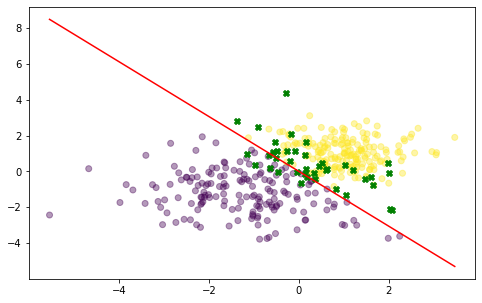

Accuracy 90.0% - 360 correct and 40 wrong


In [8]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=400,
    n_features=2,
    centers=([-1, -1], [1, 1]),
    cluster_std=(1.4, 0.8),
    random_state=42,
)
p = Perceptron(max_iters=10, random_state=42)
p.fit(data, classes)

slope = - p._weights[0] / p._weights[1]
plt.figure(figsize=(8, 5))
wrong_data = classes != p.predict(data) # get missclassified data
correct_data = np.logical_not(wrong_data) # get correct data
plt.scatter(data[correct_data,0], data[correct_data,1], c=classes[correct_data], alpha=0.4) # plot correct data
plt.scatter(data[wrong_data,0], data[wrong_data,1], marker='X', c='g') # plot missclassified data
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0], slope * data.max(axis=0)[0]], 
    c='r') # plot hyperplane
plt.show()
print(f"Accuracy {correct_data.sum() / data.shape[0] * 100}% - {correct_data.sum()} correct and {wrong_data.sum()} wrong")

Moreover, we can play with the number of iterations to see, what are the best results.

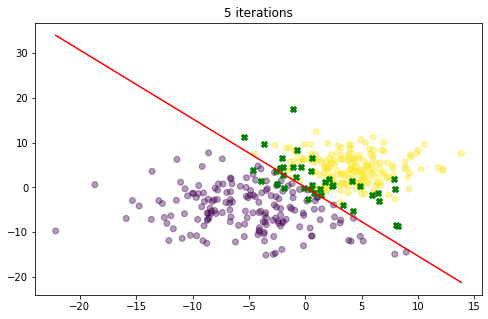

For 5 iterations is accuracy 90.0% - 360 correct and 40 wrong


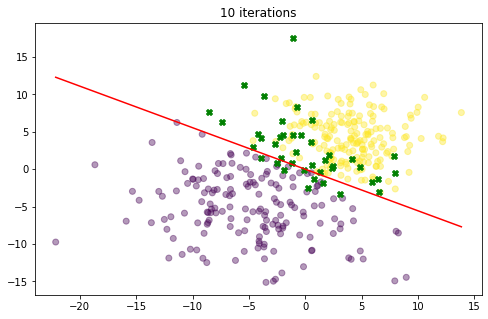

For 10 iterations is accuracy 89.75% - 359 correct and 41 wrong


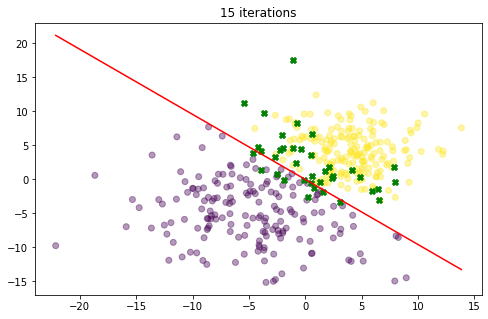

For 15 iterations is accuracy 90.5% - 362 correct and 38 wrong


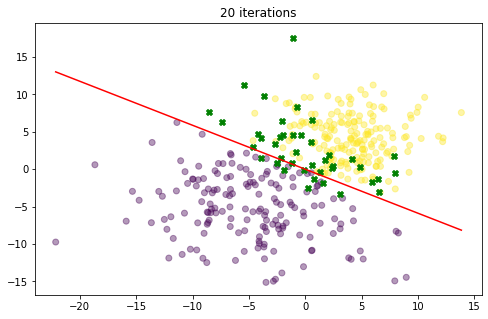

For 20 iterations is accuracy 89.75% - 359 correct and 41 wrong


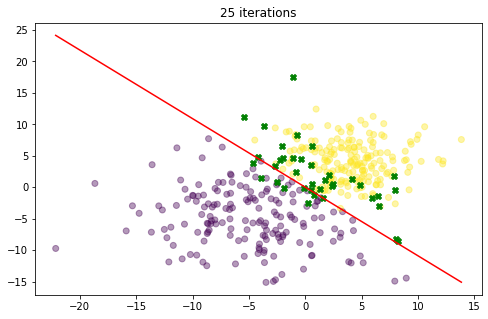

For 25 iterations is accuracy 90.5% - 362 correct and 38 wrong


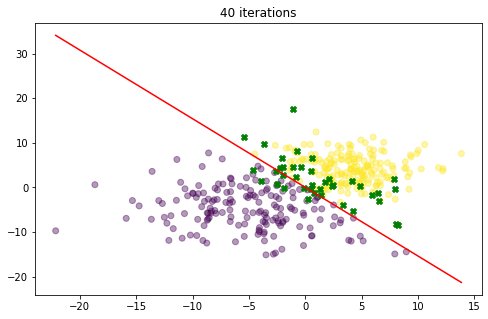

For 40 iterations is accuracy 90.0% - 360 correct and 40 wrong


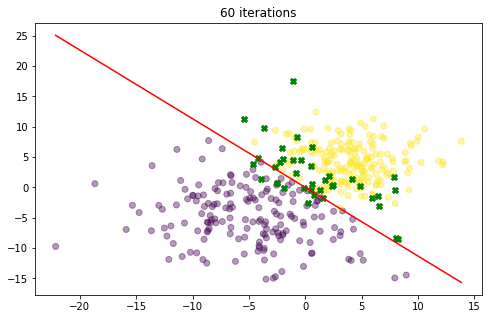

For 60 iterations is accuracy 90.5% - 362 correct and 38 wrong


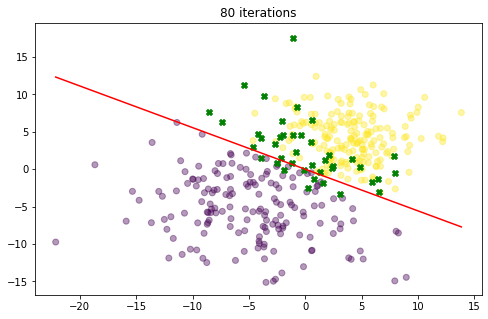

For 80 iterations is accuracy 89.75% - 359 correct and 41 wrong


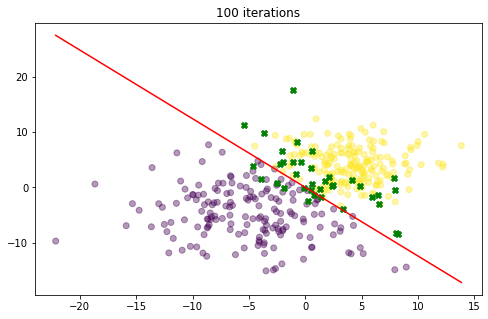

For 100 iterations is accuracy 90.75% - 363 correct and 37 wrong


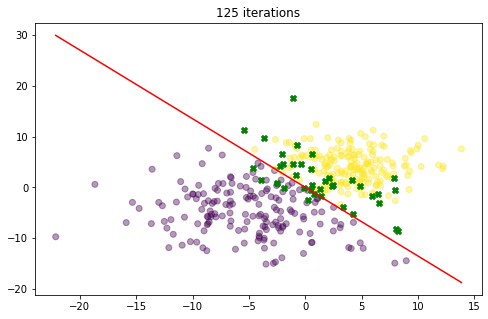

For 125 iterations is accuracy 90.5% - 362 correct and 38 wrong


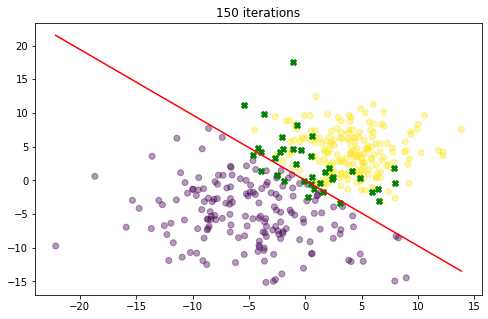

For 150 iterations is accuracy 90.5% - 362 correct and 38 wrong


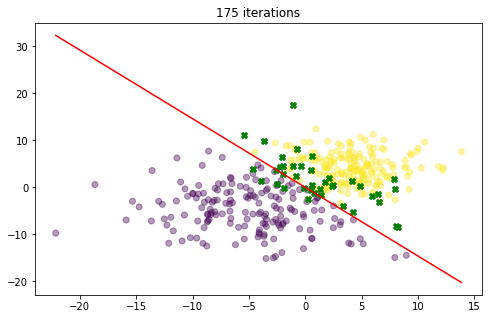

For 175 iterations is accuracy 90.0% - 360 correct and 40 wrong


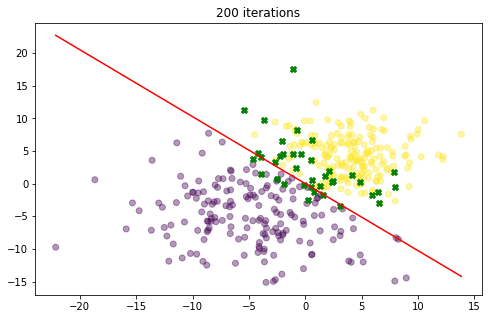

For 200 iterations is accuracy 90.5% - 362 correct and 38 wrong


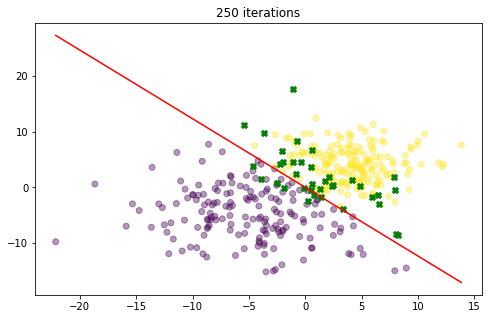

For 250 iterations is accuracy 90.75% - 363 correct and 37 wrong


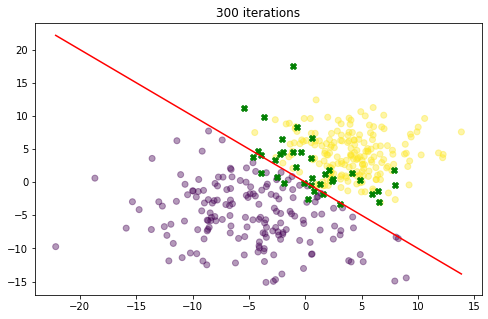

For 300 iterations is accuracy 90.5% - 362 correct and 38 wrong


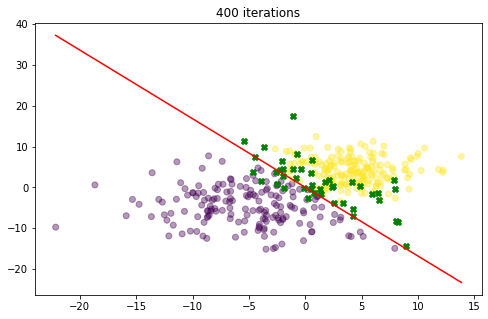

For 400 iterations is accuracy 89.0% - 356 correct and 44 wrong


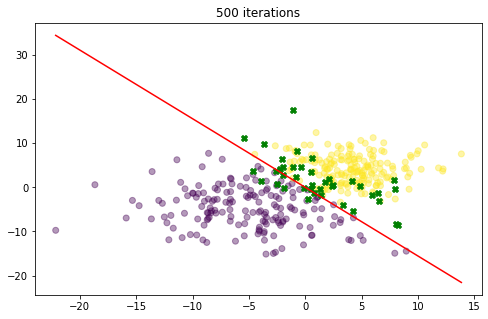

For 500 iterations is accuracy 90.0% - 360 correct and 40 wrong


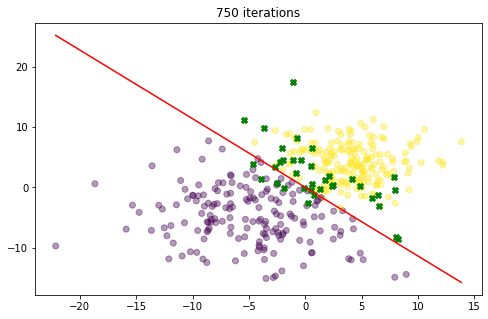

For 750 iterations is accuracy 91.0% - 364 correct and 36 wrong


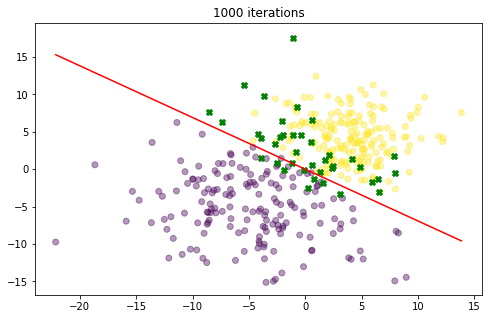

For 1000 iterations is accuracy 90.25% - 361 correct and 39 wrong


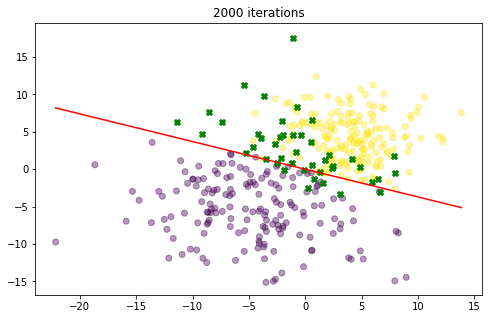

For 2000 iterations is accuracy 89.0% - 356 correct and 44 wrong


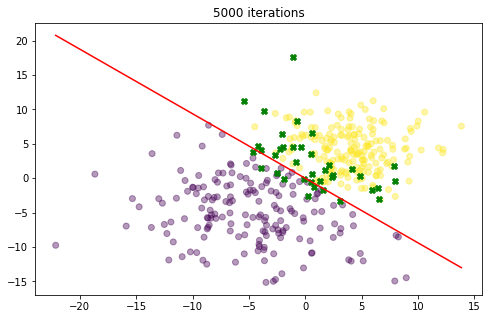

For 5000 iterations is accuracy 90.5% - 362 correct and 38 wrong


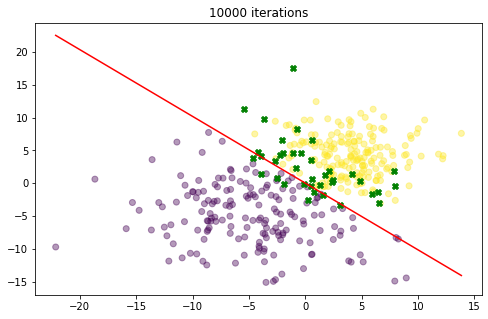

For 10000 iterations is accuracy 90.5% - 362 correct and 38 wrong


In [9]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=400,
    n_features=2,
    centers=([-1*4, -1*4], [1*4, 1*4]),
    cluster_std=(1.4*4, 0.8*4),
    random_state=42,
)

for max_iters in [5, 10, 15, 20, 25, 40, 60, 80, 100, 125, 150, 175, 200, 250, 300, 400, 500, 750, 1000, 2000, 5000, 10000]:
    p = Perceptron(max_iters=max_iters, random_state=max_iters)
    p.fit(data, classes)

    slope = - p._weights[0] / p._weights[1]
    plt.figure(figsize=(8, 5))
    wrong_data = classes != p.predict(data) # get missclassified data
    correct_data = np.logical_not(wrong_data)
    plt.scatter(data[correct_data,0], data[correct_data,1], c=classes[correct_data], alpha=0.4) # plot correct data
    plt.scatter(data[wrong_data,0], data[wrong_data,1], marker='X', c='g') # plot missclassified data
    plt.plot(
        [data.min(axis=0)[0], data.max(0)[0]], 
        [slope * data.min(axis=0)[0], slope * data.max(axis=0)[0]], 
        c='r') # plot hyperplane
    plt.title(f"{max_iters} iterations")
    plt.show()
    print(f"For {max_iters} iterations is accuracy {correct_data.sum() / data.shape[0] * 100}% - {correct_data.sum()} correct and {wrong_data.sum()} wrong")

The results are almost similar. With the increasing number of iterations, probability of finding better hyperplane is increasing, however as the results shows, with 10000 iterations we have only $90\%$ accuracy, whereas the best accuracy $90.75\%$ is achieved with 175 iterations (or 500 or 750).

From the probability point of view, the expected accuracy is around $90.55%$. Even with only $90\%$ accuracy, I think the result is still good enough.

# MNIST classification

Let's finally try something practical. Now, when we have our Perceptron model, let's try it on the MNIST dataset. MNIST is set of hand written digits and the task is to tell, what digit is in the picture. You can see some example digits below.

![MNIST dataset example](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

As the perceptron can only distinguish between two classes, we will *one-to-one* approach. In general, we will have more estimators - for every class pair one - and we will pick up digit, that is most often in the predictions. Firstly, let't load the MNIST dataset using `sklearn`. 

In [1]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True)
X = np.hstack([X, np.ones((X.shape[0],1))])
train_X, test_X, train_y, test_y = sklearn.model_selection.train_test_split(
    X, y.astype(int), 
    test_size=0.2, random_state=42)

NameError: name 'sklearn' is not defined

Now, lets train the models. As we need one Perceptron for each class pair, I will use two for loops. Note that the training complexity is a bit reduced, as each perceptron is trained only for relevant classes, not the whole dataset. 

In [12]:
# train models
models = np.empty((10,10), dtype=object)
for i in range(10):
    for j in range(i):
        models[i][j] = Perceptron(max_iters=100, random_state=42)
        mask = np.logical_or(train_y == i, train_y == j)
        current_X = train_X[mask]
        current_y = (train_y[mask] - j) / (i - j)
        models[i][j].fit(current_X, current_y)

The prediction is made the same way as training. The only difference is that the final prediction is made as class, that is predicted most often.

In [13]:
# predict
predictions = np.zeros((test_y.shape[0], 10), dtype=int)
for i in range(10):
    for j in range(i):
        prediction = models[i][j].predict(test_X)
        predictions[prediction == 0, j] += 1
        predictions[prediction == 1, i] += 1
predictions = predictions.argmax(axis=1)

I can now measure the accuracy score on the test set.

In [14]:
# accuracy
print(f"Accuracy: {sklearn.metrics.accuracy_score(test_y, predictions)}")

Accuracy: 0.9225714285714286


Just for a quick comparison, let's see what would be accuracy of logistic regression.

In [22]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=100, random_state=42)
model.fit(train_X, train_y)
predictions = model.predict(test_X)
print(f"Logistic accuracy {sklearn.metrics.accuracy_score(test_y, predictions)}")

Logistic accuracy 0.9183571428571429


c:\program files\python375\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.


Based on the numbers, it seems like our perceptron is a better around $0.4\%$, however the logistic regression didn't converged and use diefferent strategy (one-vs-rest instead of one-vs-one). The logistic training is trained much faster as well (indeed, it doesn't train quadratic number of estimators). The logistic regression has some other interesting properties - so it will be our next topic.

# Bibliography

[1] Perceptron-Based Learning Algorithms, Stephen I. Gallant, 2 June 1990 